Here's a comprehensive notebook looking at how one can fit a rough WCS and then refined distortion map from all-sky camera images

In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from scipy.optimize import minimize
import glob
import os
import sys

from read_ybc import readYBC
from read_stars import read_manual_stars
from wcs_utils import apply_wcs_to_photometry, radec2altaz

from lsst.all_sky_phot.wcs import wcs_zea, wcs_refine_zea, fit_xyshifts, Fisheye
from lsst.all_sky_phot import phot_night, readcr2

from astropy.io import fits
from astropy import wcs
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS, Longitude, Latitude
import astropy.units as u
from astropy.time import Time
from astropy.table import Table, vstack
from astropy import units as u

from photutils import CircularAperture

Using a star map and ds9, put together a file listing the x,y,mjd positions of known stars

In [2]:
# Read in stars measured off several exposures
stars = read_manual_stars('starcoords.dat')
stars

If you need enough precision such that this matters (~<10 arcsec), you can
use the latest IERS predictions by running:

    >>> from astropy.utils import iers
    >>> iers.IERS.iers_table = iers.IERS_A.open(iers.IERS_A_URL)

 [astropy.coordinates.builtin_frames.utils]
If you need enough precision such that this matters (~<10 arcsec), you can
use the latest IERS predictions by running:

    >>> from astropy.utils import iers
    >>> iers.IERS.iers_table = iers.IERS_A.open(iers.IERS_A_URL)

 [astropy.coordinates.builtin_frames.utils]


array([ ('Achernar', 3441.0, 2918.0, 57415.03236111111, 49.947050461141515, 215.1280625253878),
       ('Achernar', 3576.0, 3018.0, 57415.06576388889, 43.715460044327585, 217.98734214492922),
       ('Betelgeuse', 2123.0, 971.0, 57415.01190972222, 43.319872170968644, 40.984431336638984),
       ('Betelgeuse', 2330.0, 956.0, 57415.03236111111, 47.122656796538564, 32.091831385823845),
       ('Betelgeuse', 2677.0, 949.0, 57415.06576388889, 51.30177229534061, 14.886238412655885),
       ('Canopus', 2221.0, 2671.0, 57415.01190972222, 55.59320568854928, 141.12216403321605),
       ('Canopus', 2338.0, 2640.0, 57415.03236111111, 59.417680615391944, 145.4395870063344),
       ('Canopus', 2539.0, 2609.0, 57415.06576388889, 64.53278238450694, 156.57094949814072),
       ('Procyon', 1418.0, 1164.0, 57415.01190972222, 26.77820616264145, 65.70791797900411),
       ('Procyon', 1610.0, 1115.0, 57415.03236111111, 32.46281914154827, 60.339168551036586),
       ('Procyon', 1935.0, 1053.0, 57415.06576388

In [3]:
# Fit a Zenith Equal Area projection.
fun = wcs_zea(stars['x'], stars['y'], stars['alt'], stars['az'], crpix1=2.87356521e+03, crpix2=1.98559533e+03)
x0 = np.array([2.87356521e+03,   1.98559533e+03,  1., 1., .036,
        0.0027,  0.00295,   -0.0359])
fit_result = minimize(fun, x0)

In [4]:
# Convert the fit to a full WCS object
wcs_initial = fun.return_wcs(fit_result.x)

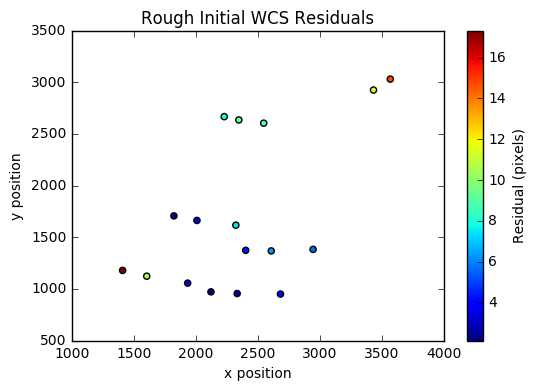

In [6]:
# Check the residuals
fit_x, fit_y = wcs_initial.all_world2pix(stars['az'], stars['alt'], 0)
resid_d = ((fit_x-stars['x'])**2+(fit_y-stars['y'])**2)**0.5
plt.scatter(fit_x, fit_y, c=resid_d)
cb = plt.colorbar()
cb.set_label('Residual (pixels)')
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Rough Initial WCS Residuals')

In [7]:
# Let's see what the result looks like
x, y = np.meshgrid(np.arange(1000,4000, 1), np.arange(500, 3500, 1))
x = x.ravel()
y = y.ravel()
az, alt = wcs_initial.all_pix2world(x,y, 0)
plt.hexbin(x,y, alt)
plt.xlabel('x position')
plt.ylabel('y position')
cb = plt.colorbar()
cb.set_label('Altitude (deg)')
plt.figure()
plt.hexbin(x,y, az)
plt.xlabel('x position')
plt.ylabel('y position')
cb = plt.colorbar()
cb.set_label('Azimuth (deg)')

In [8]:
# Now to run photometry on a full image and refine the WCS solution
# Load the Yale bright star catalog
ybc = readYBC()
# ybc_bright = np.where(ybc['Vmag'].values < 4)
# ybc_cat = SkyCoord(ra=ybc['RA'].values[ybc_bright]*u.degree, dec=ybc['Dec'].values[ybc_bright]*u.degree)

In [9]:
filename = 'ut012716/ut012716.0130.long.cr2'
#filename = 'ut012516/ut012516.0322.long.cr2'
im, header = readcr2(filename)
# Combine the RGB into a single image
sum_image = np.sum(im, axis=2).astype(float)
# Run detection and photometry
phot_tables = phot_night([filename], savefile=None, progress_bar=False)
phot_appertures = CircularAperture( (phot_tables[0]['xcenter'], phot_tables[0]['ycenter']), r=5.)
# guess the camera zeropoint
zp = -18.
measured_mags = -2.5*np.log10(phot_tables[0]['residual_aperture_sum'].data) - zp

In [10]:
# OK, let's see where we expect the stars to be
lsst_location = EarthLocation(lat=-30.2444*u.degree, lon=-70.7494*u.degree, height=2650.0*u.meter)
alt, az = radec2altaz(ybc['RA'], ybc['Dec'], header['mjd'], location=lsst_location)
above = np.where(alt > 5.)
x_expected, y_expected = wcs_initial.all_world2pix(az[above], alt[above], 0.)
apertures = CircularAperture( (x_expected, y_expected), r=5.)

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/astropy/coordinates/angles.py:672: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/astropy/coordinates/angles.py:563: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/yoachim/lsst/Darwin

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


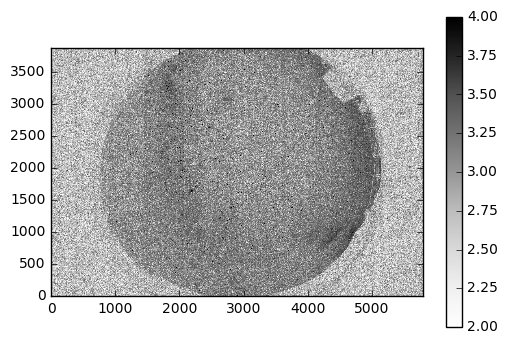

In [11]:
# Let's take a look at where the stars are, and where predicted stars are:
plt.imshow(np.log10(sum_image),  cmap='Greys', origin='lower', vmin=2, vmax=4)
plt.colorbar()

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


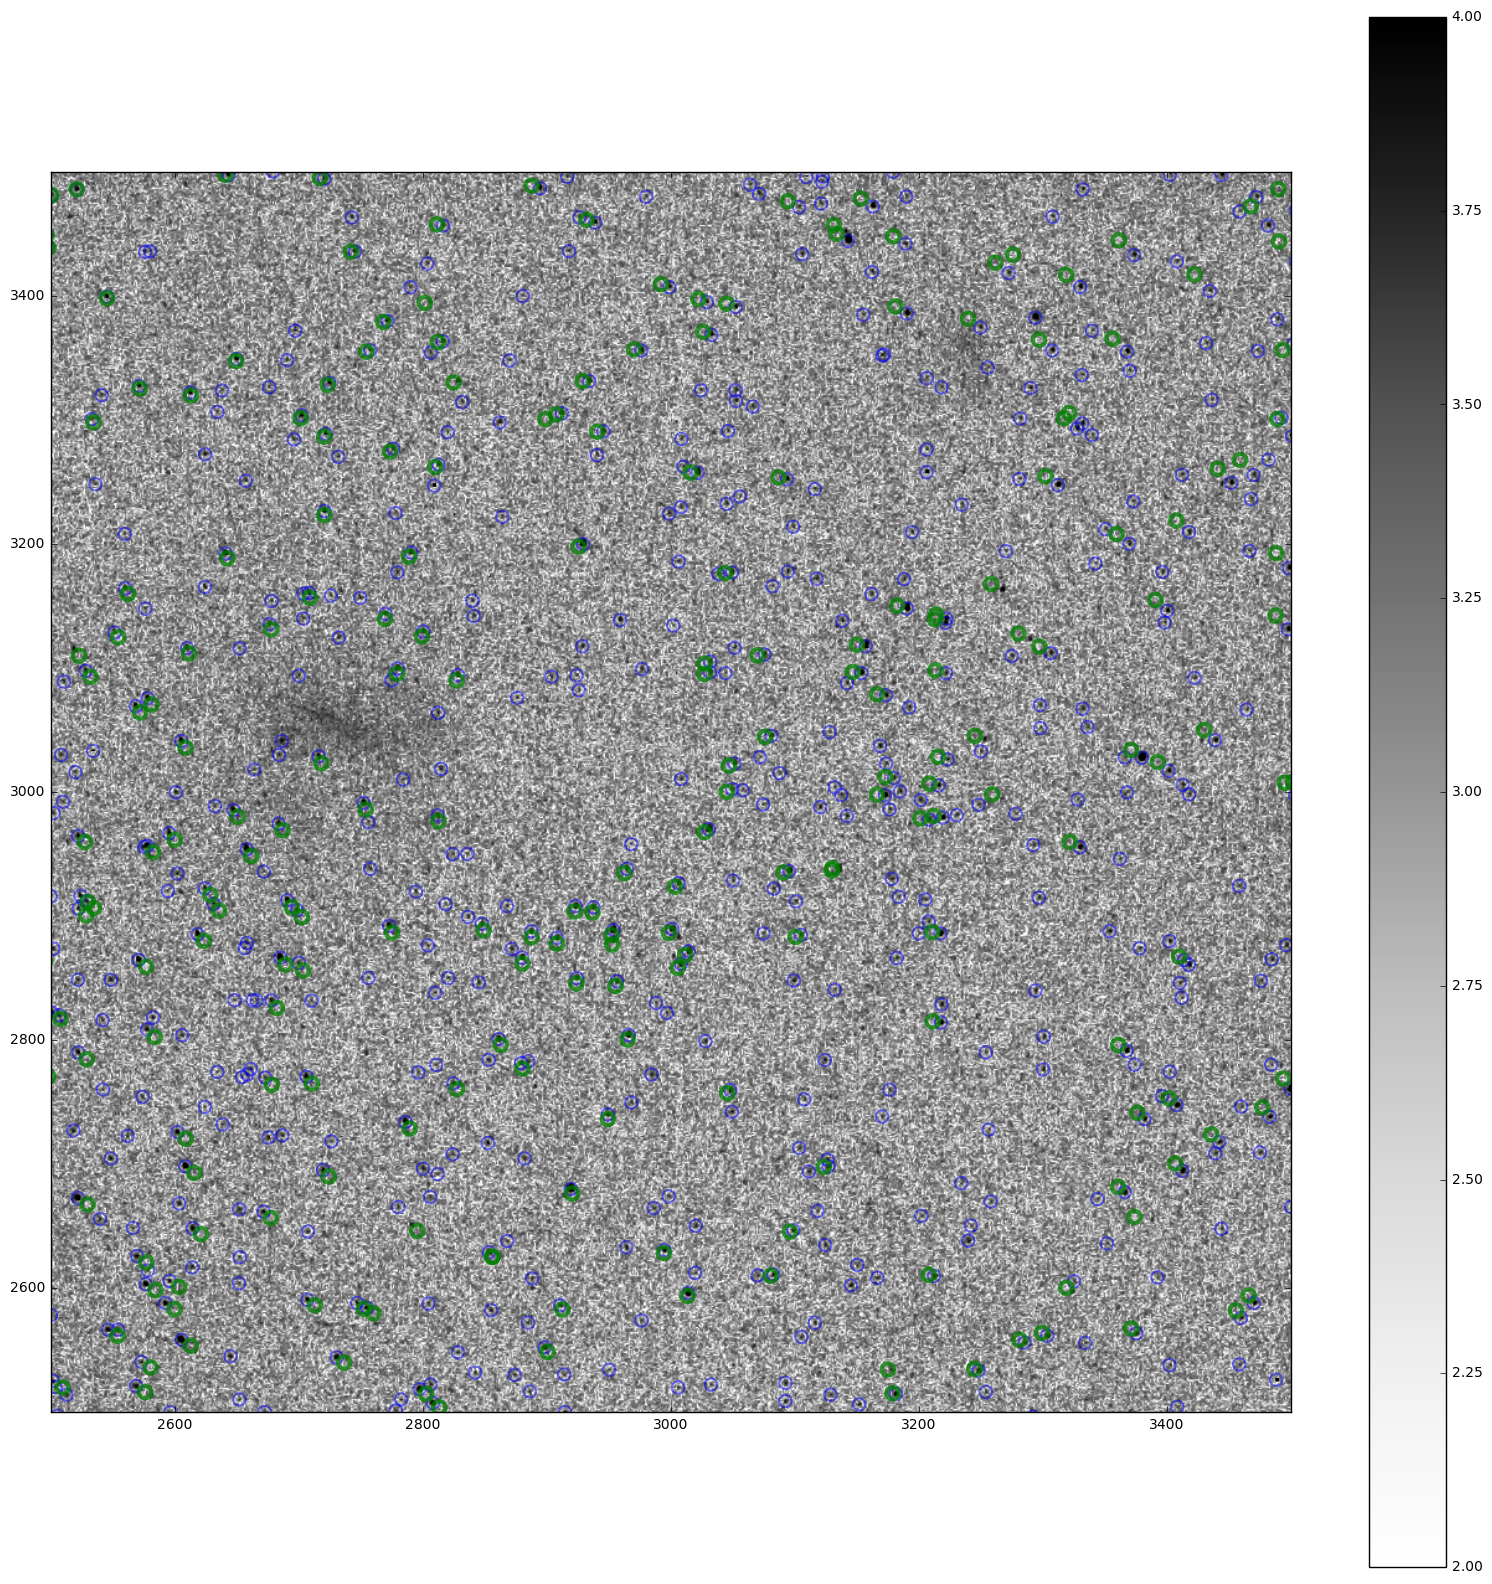

In [12]:
plt.figure(figsize=[20,20])
plt.imshow(np.log10(sum_image),  cmap='Greys', origin='lower', vmin=2, vmax=4)
plt.colorbar()
plt.xlim([2500,3500])
plt.ylim([2500,3500])
phot_appertures.plot(color='blue', lw=1.5, alpha=0.5)
apertures.plot(color='green', lw=3, alpha=0.75)

In [13]:
x0

array([  2.87356521e+03,   1.98559533e+03,   1.00000000e+00,
         1.00000000e+00,   3.60000000e-02,   2.70000000e-03,
         2.95000000e-03,  -3.59000000e-02])

In [14]:
# So, looks like the fit isn't that good. Not surprising since it was off a handful of stars measured by hand.
# Let's refine the fit. By default, not using the magnitude info.
fun = wcs_refine_zea(phot_tables[0]['xcenter'].value, phot_tables[0]['ycenter'].value, measured_mags,header['mjd'],
                     ybc['RA'].values, ybc['Dec'].values, ybc['Vmag'].values, a_order=0, b_order=0)
x0 = fun.wcs2x0(wcs_initial)
fit_result = minimize(fun, x0[0:8], method='Powell')

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/astropy/coordinates/distances.py:150: RuntimeWarning: invalid value encountered in less
  if not allow_negative and np.any(distance.value < 0):
/Users/yoachim/gitRepos/all_sky_phot/python/lsst/all_sky_phot/wcs/fit_wcs.py:312: RuntimeWarning: invalid value encountered in greater
  self.ref_catalog = self.ref_catalog[np.where(self.ref_catalog.alt.value > alt_limit)]
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/astropy/coordinates/builtin_frames/cirs_observed_transforms.py:119: RuntimeWarning: invalid value encountered in arcsin
  distance = np.sin(delta + np.arcsin(r*sindoverd))/sindoverd
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/s

In [15]:
# Check that we did imporved the fit
fun(fit_result.x) < fun(x0[0:8])

True

/Users/yoachim/lsst/DarwinX86/miniconda2/3.19.0.lsst4/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


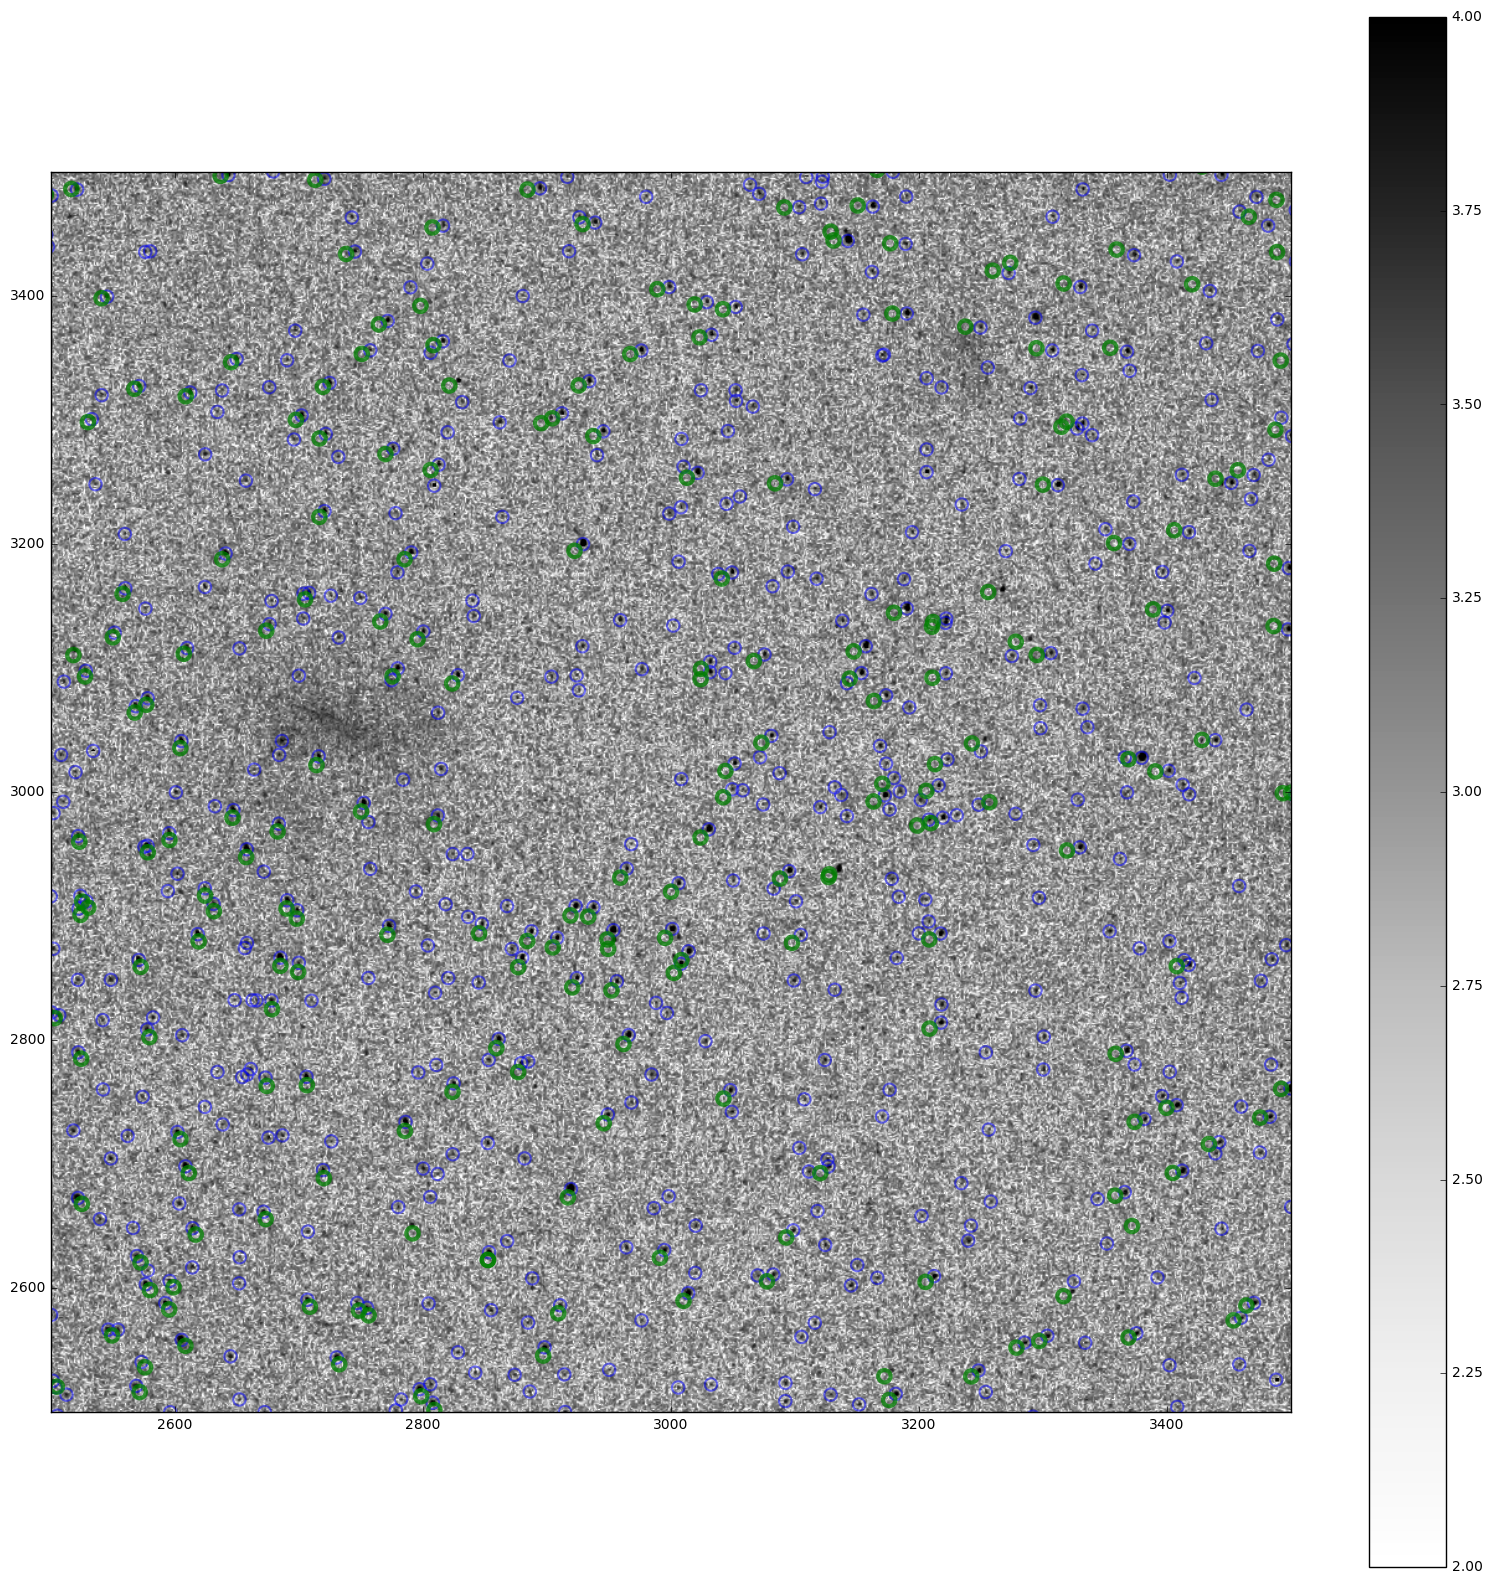

In [16]:
# Let's update the expected position of reference stars and see how we did
wcs_refined = fun.return_wcs(fit_result.x)
x_expected, y_expected = wcs_refined.all_world2pix(az[above], alt[above], 0.)
apertures = CircularAperture( (x_expected, y_expected), r=5.)

plt.figure(figsize=[20,20])
plt.imshow(np.log10(sum_image),  cmap='Greys', origin='lower', vmin=2, vmax=4)
plt.colorbar()
plt.xlim([2500,3500])
plt.ylim([2500,3500])
phot_appertures.plot(color='blue', lw=1.5, alpha=0.5)
apertures.plot(color='green', lw=3, alpha=0.75)

Looks like the expected positions are still shifted from the actual pixel positions. I was never able to get the SIP distortion terms to converge and get a significantly better fit. Let's just brute-force map out the distortions. 

Now to run detection and photometry on an entire night worth of data. 

In [17]:
# Run one night to fit, and the next to check the solution
roots = ['012616', '012716']
for root in roots:
    savefile = root+'_night_phot.npz'
    # Don't bother if already run
    if not os.path.isfile(savefile):
        files = glob.glob('ut'+root+'/*.cr2')
        phot_tables = phot_night(files, savefile=savefile)

progress = 98.90%

In [18]:
# Load up the photometry tables from the 1st night
temp = np.load('012616_night_phot.npz')
phot_tables = temp['phot_tables'][()]
temp.close()


In [ ]:
# For each frame, predict where stars should be, and fit a distortion map.

xoffsets = []
yoffsets = []
npoints = []
distances = []
maxi = float(len(phot_tables))
for i, phot_table in enumerate(phot_tables):
    alt, az = radec2altaz(ybc['RA'], ybc['Dec'], np.max(phot_table['mjd']), location=lsst_location)
    xgridpts, ygridpts, xoffs, yoffs, npt, dist = fit_xyshifts(phot_table['xcenter'].value,
                                                                     phot_table['ycenter'].value,
                                                                     alt, az, wcs_refined)
    xoffsets.append(xoffs)
    yoffsets.append(yoffs)
    npoints.append(npt)
    distances.append(dist)
    
    progress = i/maxi*100
    text = "\rprogress = %.2f%%" % progress
    sys.stdout.write(text)
    sys.stdout.flush()
    
xoffsets = np.array(xoffsets)
yoffsets = np.array(yoffsets)
npoints = np.array(npoints)
distances = np.array(distances)
# Let's save this step since it might take a while
np.savez('distortion_fits.npz', xoffsets=xoffsets, yoffsets=yoffsets, npts=npt, distances=distances,\
        xgridpts=xgridpts, ygridpts=ygridpts)